# Telcom Customer Churn Analysis
----Done by Colin Shu (https://github.com/ColinFangshu) 
<br> 7/29/2019

# Table of Contents

1.  [Introduction](#intro)
2.  [Clean dataset and EDA](#eda) 
<br>    2.1 [Clean the dataset](#import_and_drop_nan)
<br>    2.2 [EDA](#EDA)
3.  [Logistic Regression](#logreg)
<br>    3.1 [A basic logistic regression model](#Easy_LR)
<br>    3.2 [A logistic regression model with SMOTE](#SMOTE_LR)
4.  [Random Forest](#RF)
<br>    4.1 [A baseline model using single decision tree](#Easy_RF)
<br>    4.2 [A random forest model using grid searching](#P_RF)
5.  [XGBoost](#XGBoost)
6.  [Support Vestor Machine](#SVM)
7.  [K-Nearest Neighbors](#KNN)
8.  [The overall results](#Overall)
9.  [Discussions](#DIS)
<br>    9.1 [Results interpretation](#INTER)
<br>    9.2 [Future work](#FUT)

<a id='intro'><a/>
## 1. Introduction

&emsp; Churn analysis is vital to a wide range of companies, such as communication companies, newspaper companies, and dotcom companies. The major reason is that for these companies highly rely on subscription services, the extra price to gain new customers are more often higher than the maintenance costs to retain existing ones. A big mature companies even see it as one of their fundamental business.
<br>
&emsp; Since the number of customers and their data has been growing rapidly, churn analysis is also becoming one of the big data use case in business.
<br>
&emsp; Churn analysis is usually defined as a classification problem, requiring multiples features to predict the churn activity of customers. In this study, data set from Kaggle website is used, which contains 21 features and a churn activity record for each customer (https://www.kaggle.com/blastchar/telco-customer-churn). Different classification models have been built to classify the churn activity. The ROC (Receiver Operating Characteristic) curve and AUC (Area Under Curve) of each model are compared.
<br>
&emsp; 

<a id='eda'><a/>
## 2. Clean dataset and EDA

<a id='import_and_drop_nan'><a/>
### 2.1 Clean the dataset

In [ ]:
# in case the imblearn cannot be installed 
# !pip install imblearn

In [1]:
# import basic libraries
import pandas as pd
import numpy as np
np.random.seed(0)

# import the functions.py
import functions as func

# import libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import sklearn libraries for preprocessing, pipeline, model selection, model evaluation
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, confusion_matrix, auc, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA

# import logisticRegression model
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# import RandomForest model
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# import XGBoost model
from xgboost import XGBClassifier

# import Suppport Vector Machine model
from sklearn import svm

# import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# import the csv file
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
df.isna().any().any()

False

During the EDA, I found the type of the entries in column "TotalCharges" is object, which should be float64 instead. While trying to convert the string into the float, it turns out there are empty strings, which stops the convertion process. 

In [6]:
unconvertable = []
convertable = []
for string in list(df.TotalCharges.unique()):
    try :
        type(float(string)) == float
        convertable.append(string)
    except:
        unconvertable.append(string)
print(unconvertable)
print('The number of the unconvertable string:{}'.format(sum(df.TotalCharges == unconvertable[0])))

[' ']
The number of the unconvertable string:11


In [7]:
idx_to_drop = df.index[df['TotalCharges'] == unconvertable[0]]

For the rows with the empty string in column "TotalCharges", the values in other columns seems valid. Because the absurd rows are rare in this dataset(11/7043=0.0015), it is no harm to just drop them.

In [8]:
df.iloc[idx_to_drop]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [9]:
df.drop(idx_to_drop, axis=0, inplace=True)

In [10]:
df.TotalCharges = df.TotalCharges.astype(float)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), ob

In [12]:
df.loc[df.Churn == 'Yes', "Churn"] = 1
df.loc[df.Churn == 'No', "Churn"] = 0

In [13]:
df.reset_index().head().T

,0,1,2,3,4
index,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic


<a id='EDA'><a/>
### 1.2 EDA

In [14]:
features_for_hist = df.columns[1:]

In [15]:
numerical_features = ['MonthlyCharges', 'SeniorCitizen', 'TotalCharges', 'tenure']

In [16]:
categoric_features = list(set(list(features_for_hist))-set(numerical_features))

In [17]:
numerical_df = df.loc[:,numerical_features]

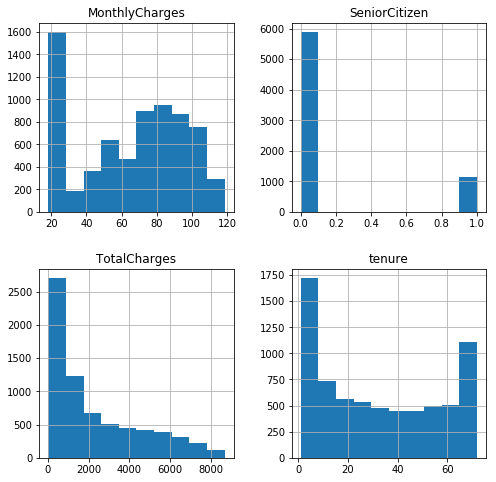

In [18]:
numerical_df.hist(figsize=(8,8));

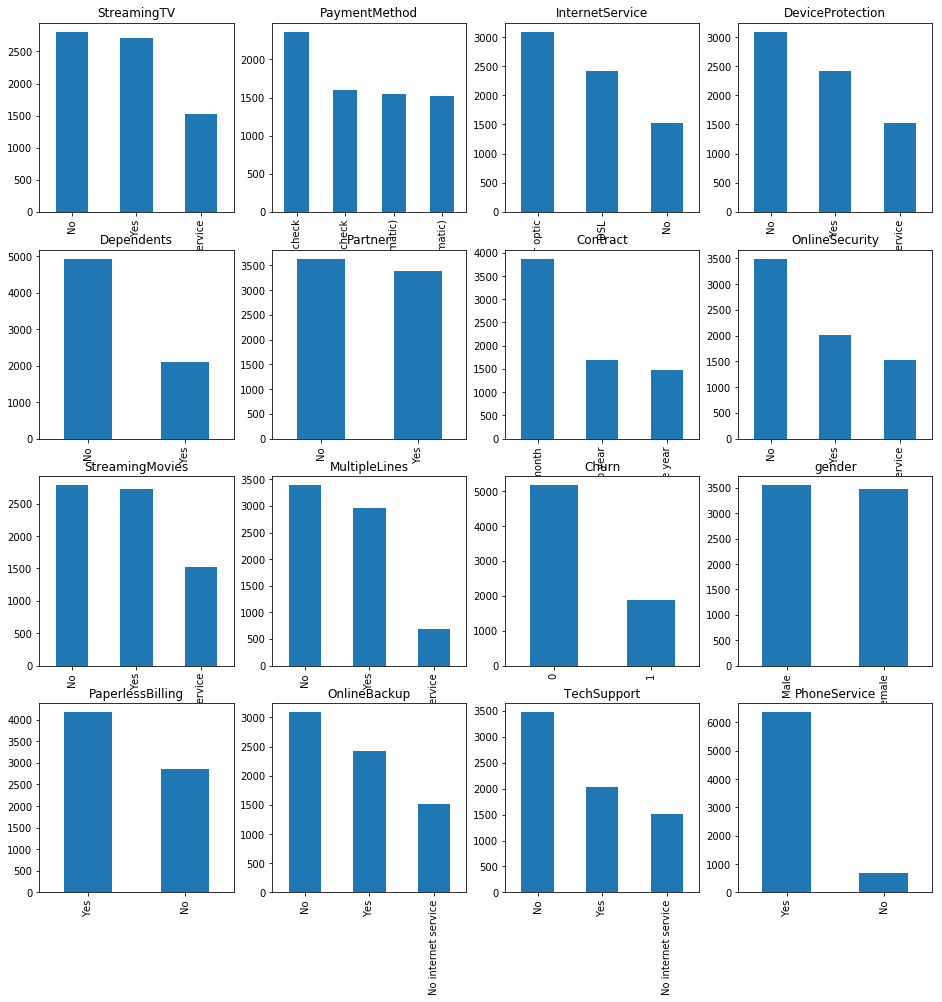

In [19]:
fig,axes = plt.subplots(4, 4, figsize=(16, 16))
for idx, feat in enumerate(categoric_features): 
    row = idx // 4
    col = idx % 4
    df[feat].value_counts().plot(ax=axes[row,col], kind='bar')
    axes[row,col].set_title(feat)

In [20]:
df.Churn.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

<a id='logreg'><a/>
## 3. Logistic Regression

<a id='Easy_LR'><a/>
### 3.1 A basic logistic regression model

Before performing the logistic regression model, we still need to preprocess the data set

In [21]:
# select the features
X = df.loc[:, ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 
               'Contract', 'MultipleLines', 'InternetService', 'PaymentMethod', 
               'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']]

In [22]:
y = df.loc[:, 'Churn']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [24]:
y_test.value_counts()

0    1311
1     447
Name: Churn, dtype: int64

In [25]:
print('The baseline for predicting the churn would be: {}'.format(round((y_test.value_counts()[1]/y_test.value_counts().sum()),3)))

The baseline for predicting the churn would be: 0.254


In [26]:
print('shape of x train set:{}'.format(X_train.shape))
print('shape of x test set:{}'.format(X_test.shape))
print('shape of y train set:{}'.format(y_train.shape))
print('shape of y test set:{}'.format(y_test.shape))

shape of x train set:(5274, 12)
shape of x test set:(1758, 12)
shape of y train set:(5274,)
shape of y test set:(1758,)


In [27]:
X_train_cat = X_train.loc[:,['gender', 'Partner', 'Dependents', 'PaperlessBilling', 
               'Contract', 'MultipleLines', 'InternetService', 'PaymentMethod', 
               'SeniorCitizen']]

In [28]:
X_test_cat = X_test.loc[:,['gender', 'Partner', 'Dependents', 'PaperlessBilling', 
               'Contract', 'MultipleLines', 'InternetService', 'PaymentMethod', 
               'SeniorCitizen']]

In [29]:
# One hot encoding transformation of categorical features of X
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_train_cat)
X_train_enc = enc.transform(X_train_cat)
X_test_enc = enc.transform(X_test_cat)

In [30]:
# Create dataframe of categorical features of X_train and X_test
cat_train_df = pd.DataFrame(X_train_enc.todense(), columns=enc.get_feature_names(X_train_cat.columns))
cat_test_df = pd.DataFrame(X_test_enc.todense(), columns=enc.get_feature_names(X_test_cat.columns))

# minmax scaling the numerical features of X_train and X_test
scaler = MinMaxScaler()
num_scaled_train = scaler.fit_transform(X_train.loc[:,['tenure', 'MonthlyCharges', 'TotalCharges']])
num_scaled_test = scaler.fit_transform(X_test.loc[:,['tenure', 'MonthlyCharges', 'TotalCharges']])
num_scaled_train_df = pd.DataFrame(num_scaled_train, columns = ['tenure', 'MonthlyCharges', 'TotalCharges'])
num_scaled_test_df = pd.DataFrame(num_scaled_test, columns = ['tenure', 'MonthlyCharges', 'TotalCharges'])

# Concatenate the categorical features of X_train and numerical features (scaled) of X_train, 
# and the categorical features of X_train and numerical features (scaled) of X_test, respectively
X_train_all_enc = pd.concat([cat_train_df, num_scaled_train_df], axis=1)
X_test_all_enc = pd.concat([cat_test_df, num_scaled_test_df], axis=1)

In [31]:
# display the top 5 instance of the train set
X_train_all_enc.head()

,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PaperlessBilling_No,PaperlessBilling_Yes,Contract_Month-to-month,Contract_One year,...,InternetService_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen_0,SeniorCitizen_1,tenure,MonthlyCharges,TotalCharges
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.899502,0.889401
1,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.943662,0.016915,0.156808
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.140845,0.705970,0.112105
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.154930,0.660199,0.115226
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.000000,0.018408,0.000150


In [32]:
logreg_1 = LogisticRegression(fit_intercept=False, C=1e12)
logreg_1.fit(X_train_all_enc, y_train)
y_hat_train_lr_1 = logreg_1.predict(X_train_all_enc)
y_hat_test_lr_1 = logreg_1.predict(X_test_all_enc)

/Users/shufang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Normalized confusion matrix
[[0.89304258 0.10695742]
 [0.44374121 0.55625879]]
Normalized confusion matrix
[[0.90617849 0.09382151]
 [0.48993289 0.51006711]]


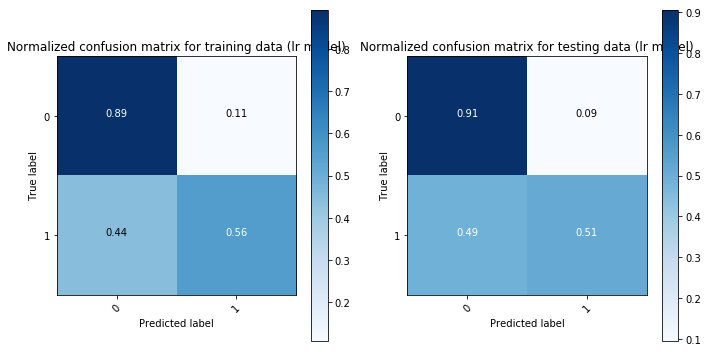

In [33]:
# plot the confusion matrix of the first model
class_names = set(y_train)
plt.figure(figsize=(10, 5))
cm_lr_1_train = confusion_matrix(y_train, y_hat_train_lr_1)
cm_lr_1_test = confusion_matrix(y_test, y_hat_test_lr_1)
plt.subplot(1, 2, 1)
func.plot_confusion_matrix(cm_lr_1_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for training data (lr model)')
plt.subplot(1, 2, 2)
func.plot_confusion_matrix(cm_lr_1_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for testing data (lr model)')

In [34]:
parameters_1 = sorted(list(zip(X_train_all_enc.columns, logreg_1.coef_[0].round(3))), key=lambda x: abs(x[1]), reverse=True)

Text(0.5, 1.0, 'The parameter weight of the one hot encoded features')

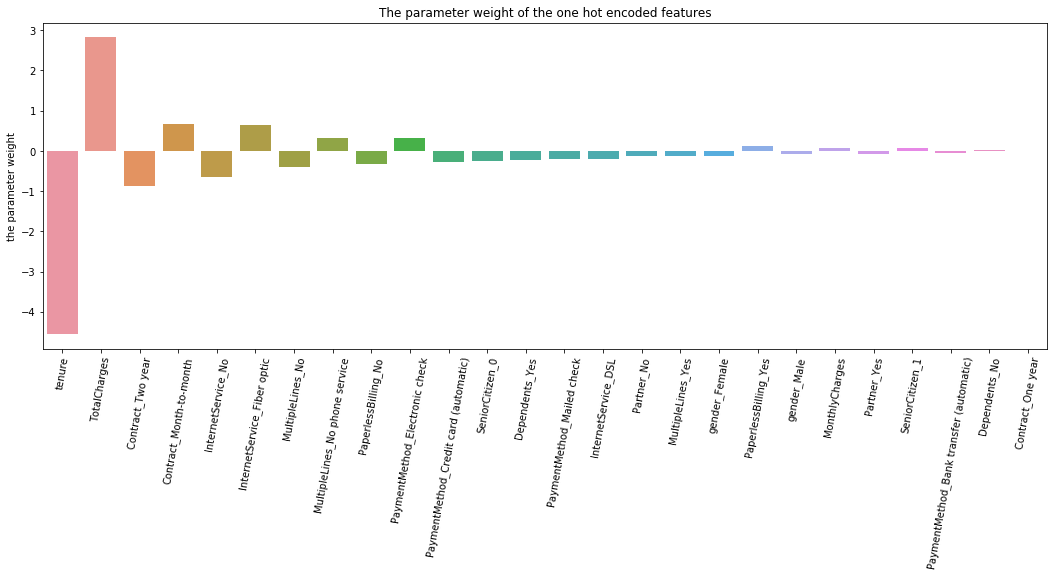

In [35]:
fig,ax = plt.subplots(figsize=(18,6))
ax = sns.barplot(x=[x[0] for x in parameters_1], y=[x[1] for x in parameters_1])
plt.ylabel('the parameter weight')
plt.xticks(rotation=80)
plt.title('The parameter weight of the one hot encoded features')

/Users/shufang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.8341797251615568


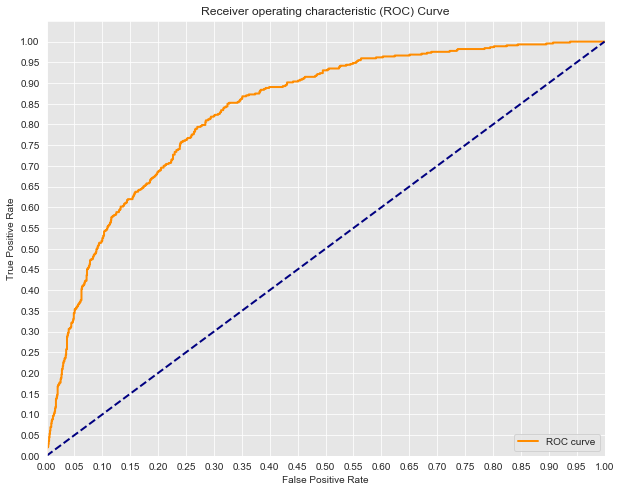

In [36]:
#Probability scores for test set
y_score_lr_1 = logreg_1.fit(X_train_all_enc, y_train).decision_function(X_test_all_enc)
#False positive Rate and true positive rate
func.plot_roc_curve(y_test, y_score_lr_1)

<a id='SMOTE_LR'><a/>
### 3.2 A logistic regression model with SMOTE

In [37]:
print(y_train.value_counts()) #Previous original class distribution
X_train_resampled, y_train_resampled = SMOTE().fit_sample(X_train_all_enc, y_train) 
print(pd.Series(y_train_resampled).value_counts()) #Preview synthetic sample class distribution

0    3852
1    1422
Name: Churn, dtype: int64
1    3852
0    3852
dtype: int64


/Users/shufang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/shufang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


AUC: 0.8331336804222403


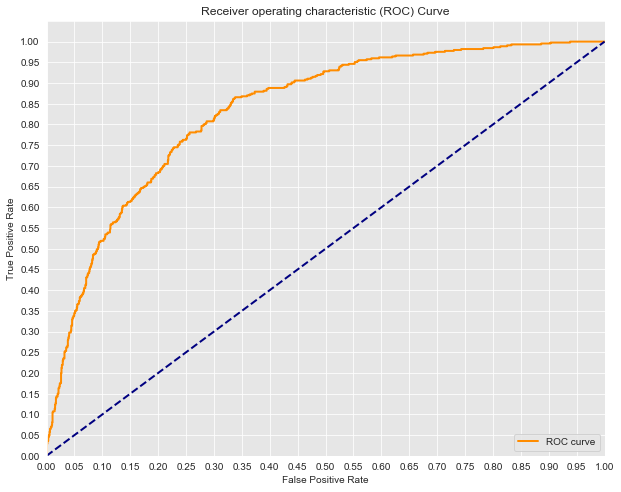

In [38]:
logreg_2 = LogisticRegression(fit_intercept=False, C=1e12)
logreg_2.fit(X_train_resampled, y_train_resampled)
y_hat_test_lr_2 = logreg_2.predict(X_test_all_enc)
y_hat_train_lr_2 = logreg_2.predict(X_train_resampled)
y_score_lr_2 = logreg_2.fit(X_train_resampled, y_train_resampled).decision_function(X_test_all_enc)
# fpr, tpr, thresholds = roc_curve(y_test, y_score_lr_2)
func.plot_roc_curve(y_test, y_score_lr_2)

Normalized confusion matrix
[[0.72897196 0.27102804]
 [0.18431983 0.81568017]]
Normalized confusion matrix
[[0.72768879 0.27231121]
 [0.21700224 0.78299776]]


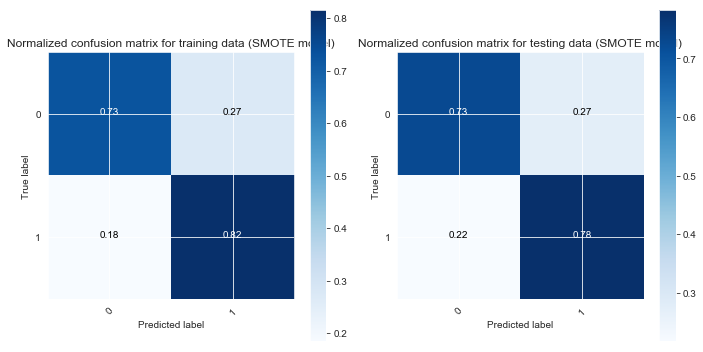

In [39]:
# plot the confusion matrix of the second model
class_names = set(y_train)
plt.figure(figsize=(10, 5))
cm_lr_2_train = confusion_matrix(y_train_resampled, y_hat_train_lr_2)
cm_lr_2_test = confusion_matrix(y_test, y_hat_test_lr_2)
plt.subplot(1, 2, 1)
func.plot_confusion_matrix(cm_lr_2_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for training data (SMOTE model)')
plt.subplot(1, 2, 2)
func.plot_confusion_matrix(cm_lr_2_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for testing data (SMOTE model)')

In [40]:
y_score_lr_2

array([ 0.22527349, -0.946251  , -0.58655702, ...,  1.0895508 ,
       -2.56739302, -5.41818277])

According to the AUC score, the SMOTE method shows little impact on improving the prediction.    

<a id='RF'><a/>
## 4. Random Forest Model

<a id='Easy_RF'><a/>
### 4.1 A baseline model using a single decision tree

In [41]:
clf_gini_dt = DecisionTreeClassifier(criterion='gini')
clf_gini_dt.fit(X_train_all_enc, y_train)
y_hat_test_dt = clf_gini_dt.predict(X_test_all_enc)
y_hat_train_dt = clf_gini_dt.predict(X_train_all_enc)

Normalized confusion matrix
[[9.99480789e-01 5.19210800e-04]
 [7.73558368e-03 9.92264416e-01]]
Normalized confusion matrix
[[0.81693364 0.18306636]
 [0.5212528  0.4787472 ]]


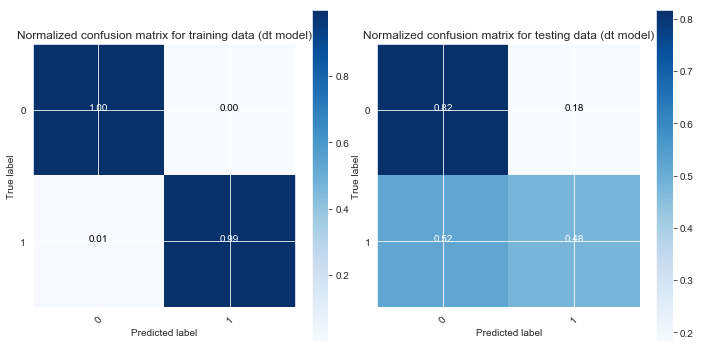

In [42]:
# plot the confusion matrix of the third model
class_names = set(y_train)
plt.figure(figsize=(10, 5))
cm_dt_1_train = confusion_matrix(y_train, y_hat_train_dt)
cm_dt_1_test = confusion_matrix(y_test, y_hat_test_dt)
plt.subplot(1, 2, 1)
func.plot_confusion_matrix(cm_dt_1_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for training data (dt model)')
plt.subplot(1, 2, 2)
func.plot_confusion_matrix(cm_dt_1_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for testing data (dt model)')

<a id='P_RF'><a/>
### 4.2 A random forest model using grid searching

In [ ]:
# Create the grid parameter
grid = [{'n_estimators': [30, 60, 90, 120], 
         'max_depth': [10, 20, 40, None], 
         'criterion': ['gini', 'entropy'],
         }]

rf = RandomForestClassifier()

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=rf,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train_all_enc, y_train)

In [ ]:
best_parameters = gridsearch.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [43]:
rf = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=90)
rf.fit(X_train_all_enc, y_train)
y_hat_test_rf = rf.predict(X_test_all_enc)
y_hat_train_rf = rf.predict(X_train_all_enc)

Normalized confusion matrix
[[0.94080997 0.05919003]
 [0.34036568 0.65963432]]
Normalized confusion matrix
[[0.91151793 0.08848207]
 [0.5212528  0.4787472 ]]


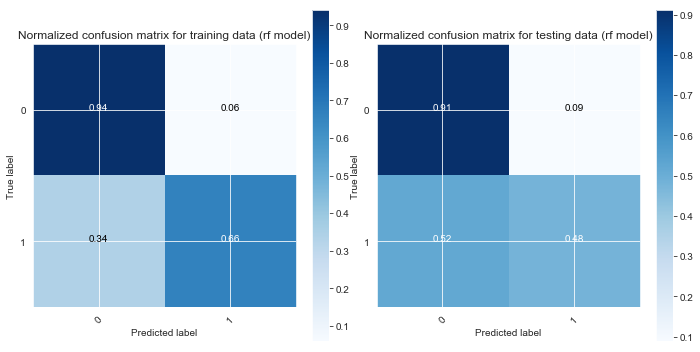

In [44]:
# plot the confusion matrix of the fourth model
class_names = set(y_train)
plt.figure(figsize=(10, 5))
cm_rf_1_train = confusion_matrix(y_train, y_hat_train_rf)
cm_rf_1_test = confusion_matrix(y_test, y_hat_test_rf)
plt.subplot(1, 2, 1)
func.plot_confusion_matrix(cm_rf_1_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for training data (rf model)')
plt.subplot(1, 2, 2)
func.plot_confusion_matrix(cm_rf_1_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for testing data (rf model)')

AUC: 0.8367001298597139


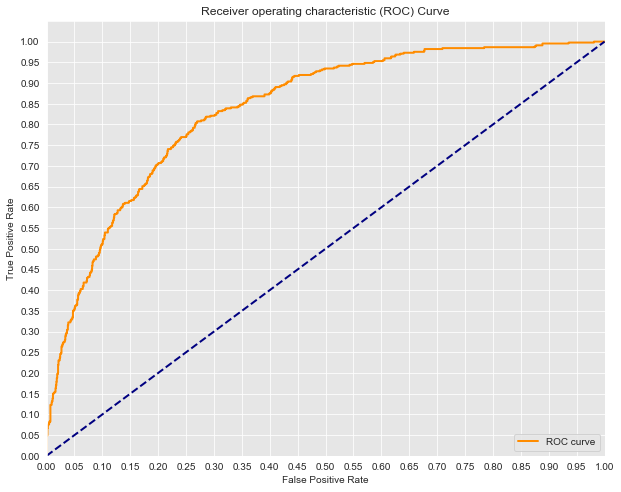

In [45]:
y_score_rf = rf.fit(X_train_all_enc, y_train).predict_proba(X_test_all_enc)
func.plot_roc_curve(y_test, y_score_rf[:,1])

<a id='XGBoost'><a/>
## 5. XGBoost Model

In [ ]:
param_grid = {
    "learning_rate": [0.05, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [5, 10, 15],
    'subsample': [0.5, 0.7],
    'n_estimators': [5, 30, 100, 250],
}

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=XGBClassifier(),
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train_all_enc, y_train)

In [ ]:
best_parameters = gridsearch.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [46]:
clf_xgb = XGBClassifier(learning_rate=0.05, max_depth=4, min_child_weight=10, n_estimators=100, subsample=0.5)
clf_xgb.fit(X_train_all_enc, y_train)
y_hat_test_xgb = clf_xgb.predict(X_test_all_enc)
y_hat_train_xgb = clf_xgb.predict(X_train_all_enc)

Normalized confusion matrix
[[0.903946   0.096054  ]
 [0.42264416 0.57735584]]
Normalized confusion matrix
[[0.90541571 0.09458429]
 [0.48769575 0.51230425]]


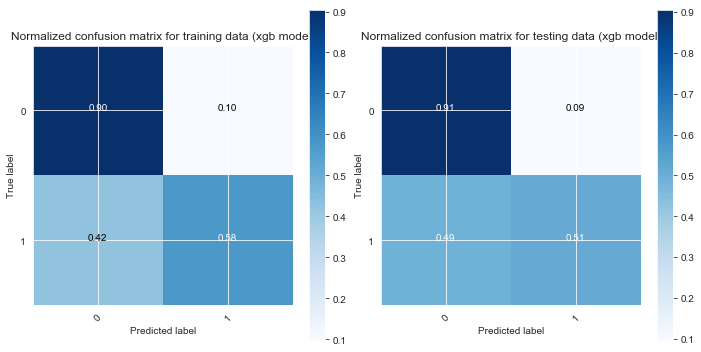

In [47]:
# plot the confusion matrix of the fifth model
class_names = set(y_train)
plt.figure(figsize=(10, 5))
cm_xgb_train = confusion_matrix(y_train, y_hat_train_xgb)
cm_xgb_test = confusion_matrix(y_test, y_hat_test_xgb)
plt.subplot(1, 2, 1)
func.plot_confusion_matrix(cm_xgb_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for training data (xgb model)')
plt.subplot(1, 2, 2)
func.plot_confusion_matrix(cm_xgb_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for testing data (xgb model)')

AUC: 0.8386599706151869


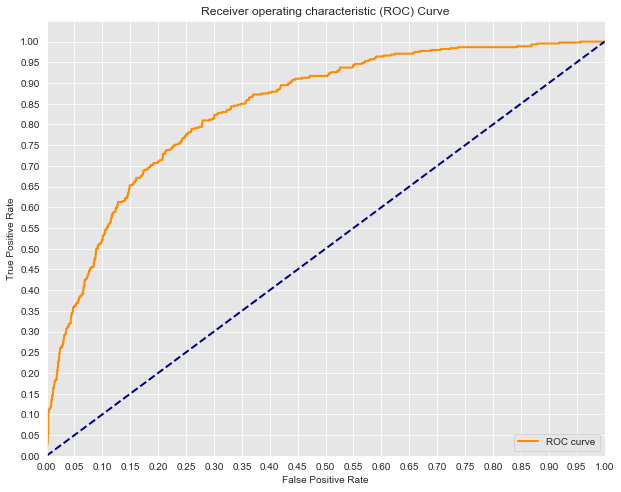

In [48]:
y_score_xgb = clf_xgb.fit(X_train_all_enc, y_train).predict_proba(X_test_all_enc)
func.plot_roc_curve(y_test, y_score_xgb[:,1])

<a id='SVM'><a/>
## 6. Support Vector Machine Model

In [ ]:
pipe = Pipeline([('pca', PCA(n_components=10)),
                ('svm', svm.SVC(random_state=123))])
grid = [{'svm__kernel':['poly','sigmoid'],
        'svm__C':[0.01, 1, 100],
        'svm__degree':[2, 3, 4, 5],
        'svm__gamma':[0.001, 0.01]}]
gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         scoring='accuracy', cv=3)
gridsearch.fit(X_train_all_enc, y_train)

In [ ]:
best_parameters = gridsearch.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [49]:
clf_svm = XGBClassifier(C=1, degree=2, gamma=0.01, kernel='sigmoid')
clf_svm.fit(X_train_all_enc, y_train)
y_hat_test_svm = clf_svm.predict(X_test_all_enc)
y_hat_train_svm = clf_svm.predict(X_train_all_enc)

Normalized confusion matrix
[[0.91173416 0.08826584]
 [0.42756681 0.57243319]]
Normalized confusion matrix
[[0.90694127 0.09305873]
 [0.49440716 0.50559284]]


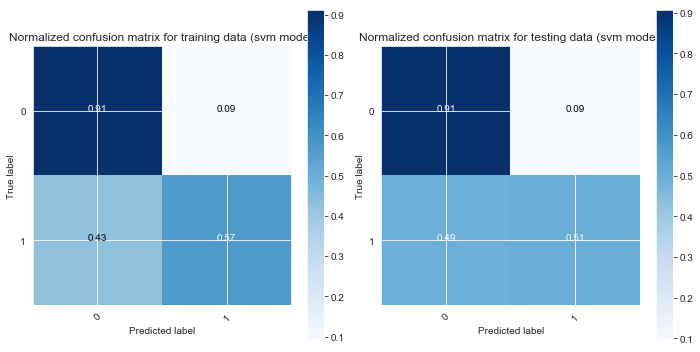

In [50]:
# plot the confusion matrix of the sixth model
class_names = set(y_train)
plt.figure(figsize=(10, 5))
cm_svm_train = confusion_matrix(y_train, y_hat_train_svm)
cm_svm_test = confusion_matrix(y_test, y_hat_test_svm)
plt.subplot(1, 2, 1)
func.plot_confusion_matrix(cm_svm_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for training data (svm model)')
plt.subplot(1, 2, 2)
func.plot_confusion_matrix(cm_svm_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for testing data (svm model)')

AUC: 0.839843383383076


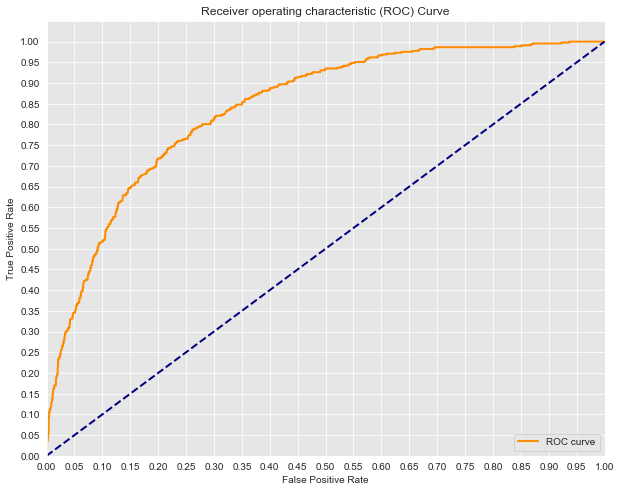

In [51]:
y_score_svm = clf_svm.fit(X_train_all_enc, y_train).predict_proba(X_test_all_enc)
func.plot_roc_curve(y_test, y_score_svm[:,1])

<a id='KNN'><a/>
## 7. K Nearest Neighbor Classifier Model

In [ ]:
pipe = Pipeline([('pca', PCA(n_components=10)),
                ('knn', KNeighborsClassifier())])
grid = [{'knn__n_neighbors':[5, 10, 15, 20],
        'knn__weights':['uniform', 'distance'],
        'knn__algorithm':['ball_tree', 'kd_tree', 'brute'],
        'knn__p':[1, 2]}]
gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         scoring='accuracy', cv=3)
gridsearch.fit(X_train_all_enc, y_train)

In [ ]:
best_parameters = gridsearch.best_params_
print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

In [52]:
clf_knn = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=10, p=1, weights='uniform')
clf_knn.fit(X_train_all_enc, y_train)
y_hat_test_knn = clf_knn.predict(X_test_all_enc)
y_hat_train_sknn = clf_knn.predict(X_train_all_enc)

Normalized confusion matrix
[[0.91173416 0.08826584]
 [0.42756681 0.57243319]]
Normalized confusion matrix
[[0.90694127 0.09305873]
 [0.49440716 0.50559284]]


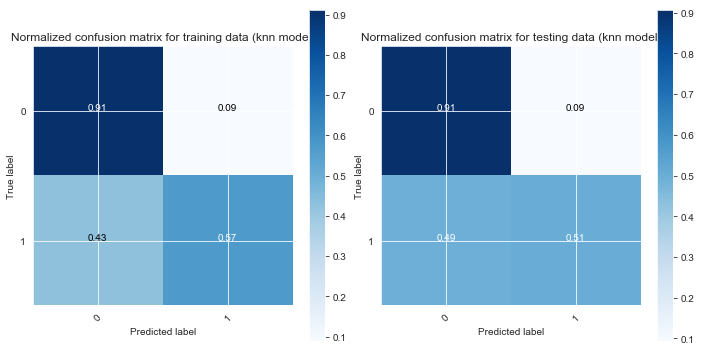

In [53]:
# plot the confusion matrix of the seventh model
class_names = set(y_train)
plt.figure(figsize=(10, 5))
cm_knn_train = confusion_matrix(y_train, y_hat_train_svm)
cm_knn_test = confusion_matrix(y_test, y_hat_test_svm)
plt.subplot(1, 2, 1)
func.plot_confusion_matrix(cm_knn_train, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for training data (knn model)')
plt.subplot(1, 2, 2)
func.plot_confusion_matrix(cm_knn_test, classes=class_names, normalize=True,
                      title='Normalized confusion matrix for testing data (knn model)')

AUC: 0.8022275804285541


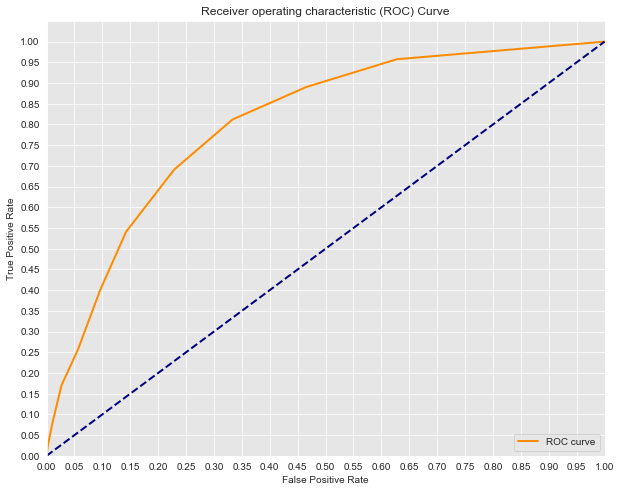

In [54]:
y_score_knn = clf_knn.fit(X_train_all_enc, y_train).predict_proba(X_test_all_enc)
func.plot_roc_curve(y_test, y_score_knn[:,1])

<a id='Overall'><a/>
## 8. The overall results

In [55]:
cm_test_list = [cm_lr_1_test, cm_lr_2_test, cm_rf_1_test, cm_xgb_test, cm_svm_test, cm_knn_test]
cm_name = ['logistic regression model', 'SMOTE model', 
           'Random Forest model','XGBoost model', 'Support Vector Machine model', 'K Nearest Neighbor model']

list_of_y_score = [y_score_lr_1, y_score_lr_2, y_score_rf, y_score_xgb, y_score_svm, y_score_knn]

In [56]:
precision_list = [func.precision(cm) for cm in cm_test_list]

recall_list = [func.recall(cm) for cm in cm_test_list]

specificity_list = [func.specificity(cm) for cm in cm_test_list]

accuracy_list = [func.accuracy(cm) for cm in cm_test_list]

F1_list = [func.F1(cm) for cm in cm_test_list]

In [57]:
auc_list = []
for y_score in list_of_y_score:
    try:
        y_score_temp = y_score[:,1]
        fpr = roc_curve(y_test, y_score_temp)[0]
        tpr = roc_curve(y_test, y_score_temp)[1]
        auc_list.append(auc(fpr, tpr))
    except:
        fpr = roc_curve(y_test, y_score)[0]
        tpr = roc_curve(y_test, y_score)[1]
        auc_list.append(auc(fpr, tpr))

In [58]:
list_of_tuples = list(zip(precision_list, recall_list, specificity_list, accuracy_list, F1_list, auc_list))

In [59]:
list_of_metric = ['precision', 'recall', 'specificity', 'accuracy', 'F1 score', 'auc score']

In [60]:
metric_score_df = pd.DataFrame(list_of_tuples, columns=list_of_metric)

In [61]:
metric_score_df.index = cm_name

In [62]:
metric_score_df

,precision,recall,specificity,accuracy,F1 score,auc score
logistic regression model,0.649573,0.510067,0.906178,0.805461,0.571429,0.834180
SMOTE model,0.495050,0.782998,0.727689,0.741752,0.606586,0.833134
Random Forest model,0.648485,0.478747,0.911518,0.801479,0.550837,0.836700
XGBoost model,0.648725,0.512304,0.905416,0.805461,0.572500,0.838660
Support Vector Machine model,0.649425,0.505593,0.906941,0.804892,0.568553,0.839843
K Nearest Neighbor model,0.649425,0.505593,0.906941,0.804892,0.568553,0.802228


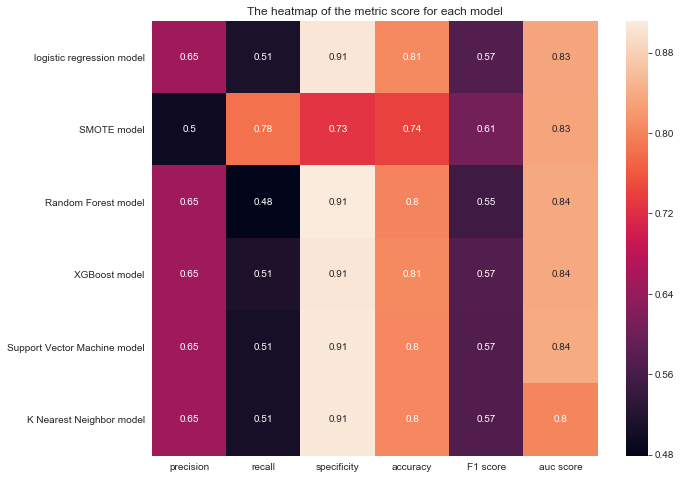

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(metric_score_df, annot=True)
plt.title('The heatmap of the metric score for each model');

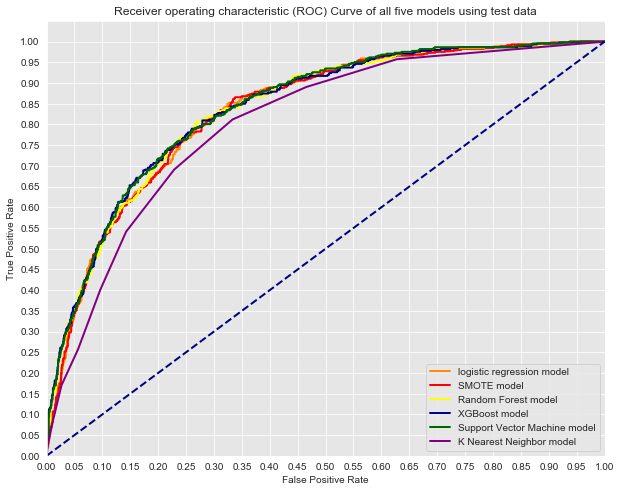

In [64]:
fpr = {}
tpr = {}
for idx,y_score in enumerate(list_of_y_score):
    if idx > 1:
        fpr[idx], tpr[idx], _ = roc_curve(y_test, y_score[:,1])
    else:
        fpr[idx], tpr[idx], _ = roc_curve(y_test, y_score)
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

fig, ax = plt.subplots(figsize=(10,8))
# plt.figure(figsize=(10,8))
lw = 2
ax = plt.plot(fpr[0], tpr[0], color='darkorange',
    lw=lw, label=cm_name[0])
ax = plt.plot(fpr[1], tpr[1], color='red',
    lw=lw, label=cm_name[1])
ax = plt.plot(fpr[2], tpr[2], color='yellow',
    lw=lw, label=cm_name[2])
ax = plt.plot(fpr[3], tpr[3], color='darkblue',
    lw=lw, label=cm_name[3])
ax = plt.plot(fpr[4], tpr[4], color='darkgreen',
    lw=lw, label=cm_name[4])
ax = plt.plot(fpr[5], tpr[5], color='purple',
    lw=lw, label=cm_name[5])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve of all five models using test data')
plt.legend(loc="lower right")
plt.show()

<a id='DIS'><a/>
## 9. Discussions

<a id='INTER'><a/>
### 9.1 Results Interpretation

&emsp; Different metric scoring methods were used to evaluate the performance of six models. Specifically, the precision score represents the ratio of the true positive to the predicted condition positive; the recall score represents the ratio of the true positive to the condition positive; the specificity score represents the ratio of true negative to the condition negative; the accuracy score represents the ratio of the sum of the true positive and the true negative to the sum of all data instances; the F1 score represents two times the ratio of the product of the precision score and the recall score to the sum of the precision score and the recall score; the auc value represents the area under the ROC curve.
<br>
&emsp; The precision score tells us among the positive prediction, of what percentage does the model detect the actual positive. In our results, other than the SMOTE model, the five models perform similar good precision. For these five models, about 65 percent of the predicted positive answer are true positive.
<br>
&emsp; The recall score instead tells us among the actual positive, of what percentage the model does pick out. In our results, SMOTE model did better at picking out the true positive. About 78 percent of the true positive cases are predicted positive in the SMOTE model.
<br>
&emsp; The specificity score tells us among the negative condition, of what percentage does the model predict the true negative. In our results, all six models reflects moderate specificity score. Other than the SMOTE model, the five models give a specificity score at about 91 percent.
<br>
&emsp; The accuracy score tells us among all cases, of what percentage does the model detects the true positive while predict the true megative. Other than the SMOTE model, the five models give a accuracy score of about 81 percent. 
<br>
&emsp; The F1 score considers both the precision score and the recall score. Higher F1 score represents a better precision and and recall, collectively. Note that it does not mean both the precision and recall are better for a higher F1 score.
<br>
&emsp; The AUC score tells us under all thresholds for a classifier, the overall results of a model. In general, all six models perform a high AUC score, with the K Nearest Neighbot model being relatively lower.

&emsp; In short, for the purpose of detecting the churn activity of customers, when we want the precision and the recall to be collectively good, we might want to look at F1 score mode. In this case, SMOTE model is more recommended.

<a id='FUT'><a/>
### 9.2 Future work

&emsp; This analysis demonstrates a good churn detection project. For future work, we could look at the churn customers deeper and perform the clustering on the churn customers to find out what kind of customer might be churn lately. Furthermore, we could look at the false positive and false negative prediction and perform the clustering on them to look at what kind of customers might be hard to predict the churn activity.
<br>
&emsp; After talking to marketing team, we can discuss how to retain the customers. For example, if we would like to send emails or give coupons. We can includes the cost and predicted profit to calculate the expected values.
<br>
&emsp; Also, before any marketing practice, our team can perform the AB test to see whether the new solution is worthy.